In [1]:
import sys
import os
import importlib

import numpy as np
import scipy
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import pyemma
import mdtraj as md

import ivac
import extq
from extq.stop import forward_stop

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2

# Load data

In [6]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
sb_models = np.load(f"{DATA_DIR}/models_centroids_feat2.npy")
# R-F161 distances
rf161 = list(np.load(f"{DATA_DIR}/raw_feat/rf161.npy", allow_pickle=True))
rf161.extend(np.load(f"{DATA_DIR}/raw_feat/rf161_anton2.npy")[:115])
rf161_arr = np.concatenate(rf161)
centroids_rf = np.load(f"{DATA_DIR}/models_centroids_rf161.npy")
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[8] # 50 ns lag time
# weights
weights = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True)[0] # 0.1 ns lag time

In [7]:
# states to do stopping
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186

# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
)

In [8]:
mask = ~(down_ids | up_ids)
traj_inds = util.split_indices(cv_trajs)
in_domain = np.split(mask, traj_inds)

# Committors

In [9]:
f223 = [t[:-lag, 0] * 10 for t in rf161] # in angstroms
f226 = [t[:-lag, 1] * 10 for t in rf161]
f229 = [t[:-lag, 2] * 10 for t in rf161]
w_delay = [w[:-lag] for w in weights]
qp_delay = []
for d, t in zip(in_domain, qp_du):
    # find first stopping time
    stop_times = np.minimum(np.arange(lag, len(d)), forward_stop(d)[:-lag])
    qp_delay.append(t[stop_times])

/scratch/local/jobs/278587/ipykernel_860976/855823693.py:5: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7fd8036aceb0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=2, labels=['_', 'Down', 'Up'])
/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom


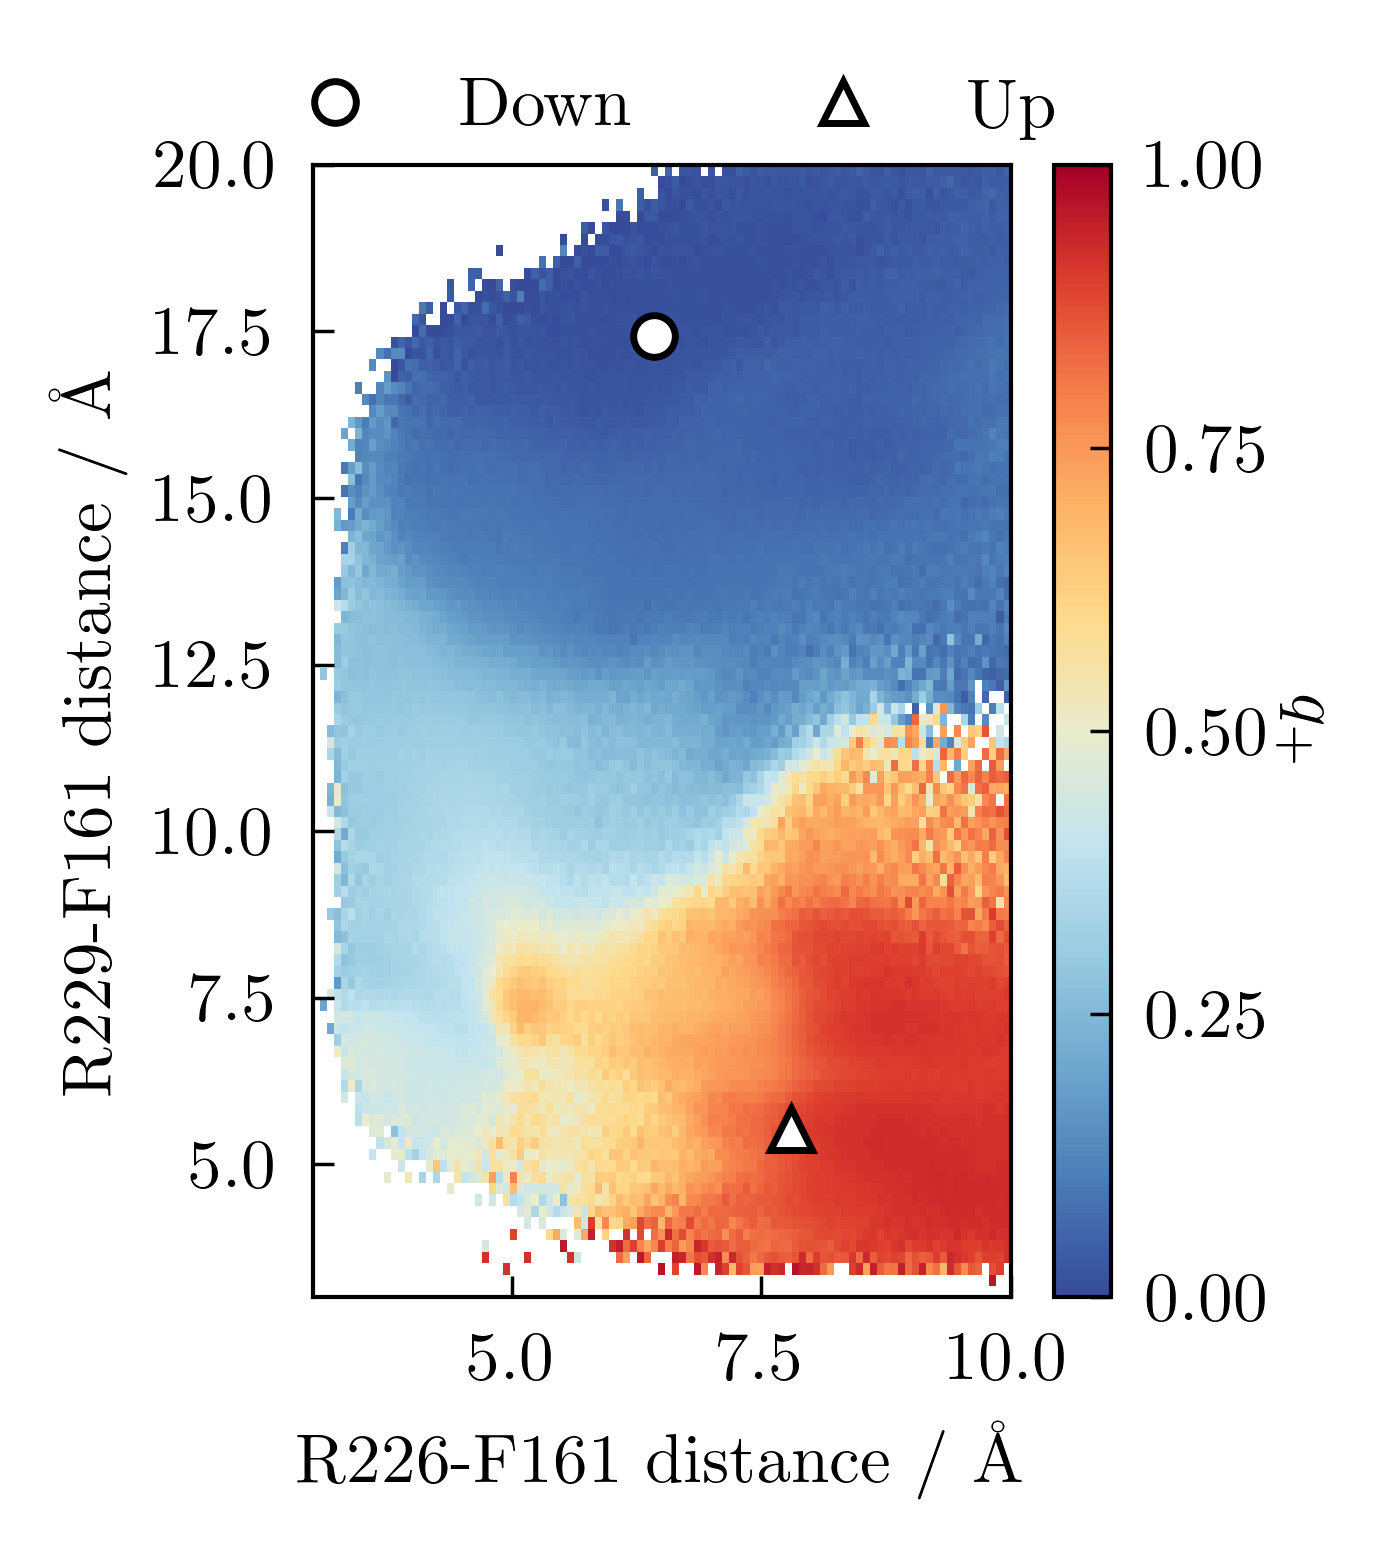

In [10]:
f = plt.figure(figsize=(2.25, 3), dpi=500)

ax = plt.gca()
plotting.plot_models(ax, centroids_rf[:, 1:] * 10, ms=6, zorder=5)
plt.legend(bbox_to_anchor=(0.5, 1.05), loc='center', ncol=2, labels=['_', 'Down', 'Up'])

xmin, xmax, ymin, ymax = 3, 10, 3, 20
xe = np.linspace(xmin, xmax, 100)
ye = np.linspace(ymin, ymax, 100)
h = extq.projection.average2d(f226, f229, qp_delay, w_delay, xe, ye)
xc = (xe[1:] + xe[:-1]) / 2
yc = (ye[1:] + ye[:-1]) / 2
levels = np.linspace(0, 1, 51)
plt.pcolormesh(xc, yc, h.T, cmap=cm_div, vmin=0, vmax=1, rasterized=True)

cb = plt.colorbar()
cb.set_label("$q_+$", rotation=-90, labelpad=10)
cb.set_ticks(np.linspace(0, 1, 5))
plt.xlabel("R226-F161 distance / Å")
plt.ylabel("R229-F161 distance / Å")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.savefig("../../fig/paper/rf_qp.pdf", bbox_inches='tight')

In [11]:
def bin_inds(q, qstep=0.05, low=0, hi=1):
    q_arr = np.concatenate(q)
    nsteps = round((hi - low) / qstep)
    all_inds = []
    steps = np.linspace(low, hi - qstep, nsteps)
    for i, s in enumerate(steps):
        q_inds = ((q_arr >= s) & (q_arr <= s + qstep)).nonzero()[0]
        all_inds.append(q_inds)
    return steps, all_inds

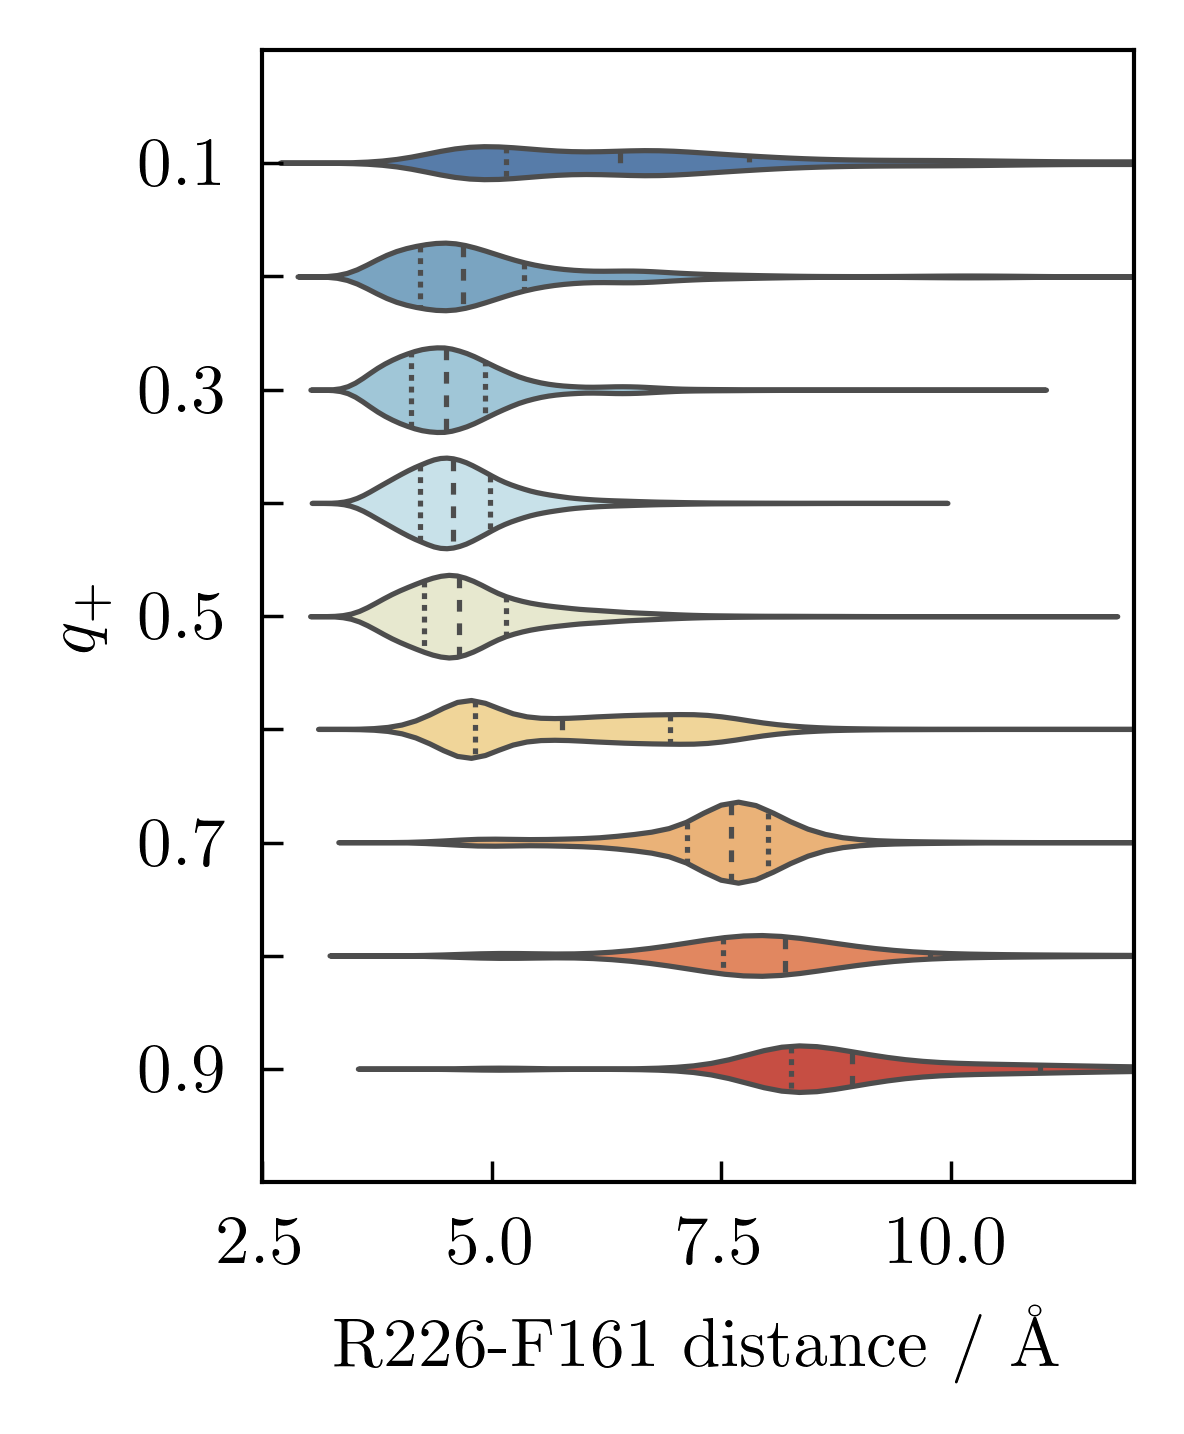

In [12]:
steps, q_inds = bin_inds(qp_du, qstep=0.1, low=0.05, hi=0.95)

steplabels = []
for i, s in enumerate(steps):
    if i % 2 == 0:
        steplabels.append(f"{s+0.05:.1f}")
    else:
        steplabels.append("")

f = plt.figure(figsize=(2.25, 3), dpi=500)
ax = plt.gca()

sns.violinplot(ax=ax, data=[rf161_arr[inds, 1] * 10 for inds in q_inds], scale='area', bw=0.1, inner="quartile", palette='diverging', orient='h')
ax.set_yticklabels(steplabels)
ax.set_xlabel(f"R226-F161 distance / Å")
ax.set_xlim([2.5, 12])
ax.set_ylim([-1, 9])
ax.set_ylabel("$q_+$")
ax.invert_yaxis()
plt.savefig("../../fig/paper/rf_violins.pdf", bbox_inches='tight')